In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd ./drive/MyDrive/Colab\ Notebooks/text_to_image_synthesis
!pwd

[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks/text_to_image_synthesis'
/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis
/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis


## Generative Adversarial Text to Image Synthesis

A challenging field of Artificial Intelligence is the automatic synthesis of images that are realistic, given text descriptions of the images written by a human.

Our approach is based on solving the following tasks:

* learn a text feature representation that captures the important visual details. 
* generate a realistic image using the text representation
 

Based on the method presented by [Scott Reed et al](https://arxiv.org/pdf/1605.05396.pdf) we use a conditional GAN, conditioned on text descriptions. We calculate the feature embeddings for the text descriptions using a Charactel Level CNN-RNN model, as described also by [Scott Reed et al, CNN-RNN](https://arxiv.org/pdf/1605.05395.pdf)

### Generative Adversarial Networks (GANs)

GANs are a framework for teaching a Deep Learning model to capture the training data's distribution so **new data** can be **generated** from that same distribution.

GANs were invented by Ian Goodfellow in 2014 and first described in the paper [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). 

They are made of two distinct models:
*   generator $ G $
*   discriminator $ D $

The job of the generator $ G $ is to spawn *fake* images that look like the training images. 

The job of the discriminator $ D $ is to look at an image and output whether or not it is a real training image or a fake image from the generator. 

The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at **50% confidence** that the generator output is real or fake.

The mathematical notation of this game is the following:

$$ \min_G \max_D V(D,G) =   \mathbb{E}_{x \sim p_{data}(x)} [logD(x)] + \mathbb{E}_{x \sim p_{z}(z)}[log(1-D(G(z)))] $$  



### Proposed Network Architecture

The proposed network architecture consists of a Deep Convolutional GAN (DC-GAN) conditioned on text features encoded by a Char CNN-RNN network.

Given:

* $ T $ the dimension of the text embedding
* $ D $ the dimenstion of the image
* $ Z $ the dimension of the noise input

then:

* the generator network $ G : \mathbb{R}^Z \times \mathbb{R}^T \to \mathbb{D} $

* the discriminator network $ D : \mathbb{R}^D \times \mathbb{R}^T \to \{0, 1\} $

The noise prior is sampled from a normal distribution.

**GAN-CLS**

If we train the network using `(text,image)` pairs as joint observations, the discriminator does not have the ability to recognize if real training images match the given text embeddings. 

In this case there are two kinds of inputs:

*   real images with matching text
*   generated images with arbitrary text

The GAN-CLS adds a third type of input to the discriminator:

* real images with fake text

This way in addition to image/image matching the image/text matching is also optimized. 

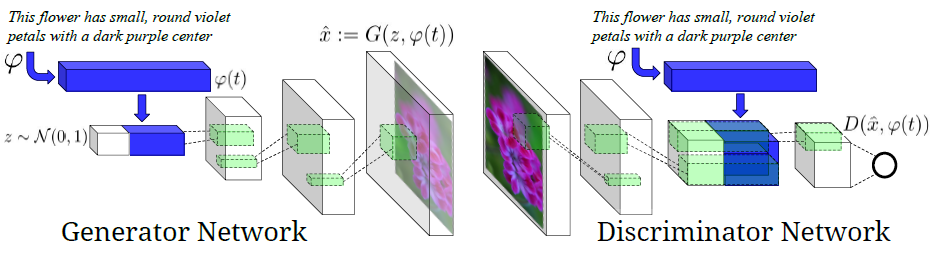

### Import Generator and Discriminator Models

A DCGAN  uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It is presented by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). 

The **discriminator** is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.

The **generator** is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, $z$, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. 

The architecture of the generator:

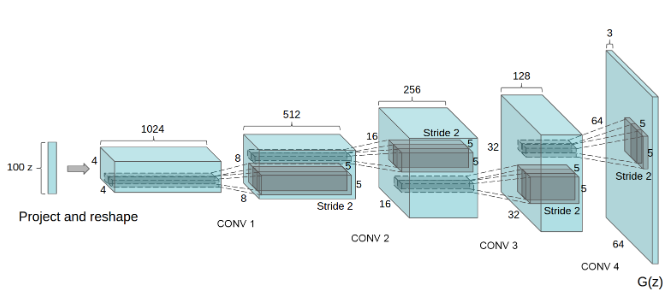

In [29]:
import os
import sys
from datetime import datetime
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from PIL import Image
from models.gan_model import generator, discriminator
import pickle
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda") 
    print(f'Models are now running on a {torch.cuda.get_device_name()} GPU')
else:
    device = torch.device("cpu")

# Number of GPUs available. 
ngpu = torch.cuda.device_count()

# Create the generator and discriminator models
netG = generator().to(device)
netD = discriminator().to(device)

**Model Parameters**

In [ ]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))

Generator Parameters: 4756736
Discriminator Parameters: 2899072


### Weights Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 

This function is applied to the models after initialization:

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [31]:
netG.apply(weights_init)
netD.apply(weights_init)

discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True

### Parameters

In [32]:
# Size of z latent vector (i.e. size of generator input)
noise_dim = 100 

# Batch size during training
batch_size = 64

# Number of workers for dataloader
num_workers = 2

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 20

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# L1 loss coefficient in the generator loss function
l1_coef = 50

# Feature matching coefficient in the generator loss function
l2_coef = 100

# True if GAN-CLS is used
cls = True

In [33]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Load Dataset and Dataloader

Download the preprocessed flowers dataset (hd5 format) from this [github](https://github.com/aelnouby/Text-to-Image-Synthesis) repository. This dataset contains the text embeddings as well as the image data from the Flowers dataset.

The Flowers dataset contains **8189 flower images**  from  **102  different  categories**. The images are split into 82 training + validation and 20 test classes.

The original  [Oxford Flowers-102 (Flowers)](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset. 

In [20]:
!cp './data/flowers.hdf5' '/content/flowers.hdf5'

In [34]:
from utils.text_to_image_dataloader import Text2ImageDataset

dataset_path = '/content/flowers.hdf5' #'./data/birds.hdf5'

# Availaible splits
# 0: train
# 1: validation
# 2: test
split = 0
dataset = Text2ImageDataset(dataset_path, split)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers)

### Training


We train and test on class-disjoint sets, so that test performance can
give a strong indication of generalization ability

**Checkpoint Saving and Metrics**

In [41]:
# Metrics
hist_D = []
hist_G = []
hist_Dx = []
hist_DGx = []
hist_FID = []

# Checkpoint path
checkpoint_dir='./models/'
save_file='gan_netG'

save_file_G='gan_netG'
save_file_D='gan_netD'

s_path = checkpoint_dir+save_file+'/'

os.makedirs(os.path.join(checkpoint_dir, save_file), exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H_%M')
model_name_G = '{}_{:.5f}_{}_{}'.format( save_file_G,
        lr , split, timestamp)
model_name_D= '{}_{:.5f}_{}_{}'.format( save_file_D,
        lr , split, timestamp)

ckpt_path_G = os.path.join(checkpoint_dir, save_file, model_name_G)
ckpt_path_D = os.path.join(checkpoint_dir, save_file, model_name_D)

**Fretchet Inception Distance**

The Frechet Inception Distance (FID) score is a metric that calculates the distance between the Inception-v3 activation distributions for real and generated images. FID was introduced in the paper [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500)

__Inception Score__

The inception score computes the KL divergence between the conditional class distribution and the marginal class distribution. It measures the quality of generated images and their diversity.

Entropy can be viewed as randomness. If the value of a random variable x is highly predictable it has low entropy. On the contrary, if it is highly unpredictable, the entropy is high. The equation to compute IS is:

    IS(G) = exp(Ex∼pg DKL(p(y|x)‖p(y) ))

__Conditional probability__: We want the conditional probability P(y|x) to be highly predictable (low entropy). For example, given an image we should know the object type easily. So we use an inception network to classify the generated images and predict P(y|x) where y is the label and x is the generated data. This reflects the quality of the images.

__Marginal probability__: The marginal probability is computed as:

    P(y) = p(y|x = G(z))dz

If the generated images are diverse, the data distribution for y should be uniform (high entropy).

One shortcoming for IS is that it can misrepresent the performance if it only generates one image per class. p(y) will still be uniform even though the diversity is low.

**FID** is a more principled and comprehensive metric and has been shown to be more consistent with human evaluation in assessing the realism and variation of the generated samples.

The calculation can be divided into three parts:

1. The Inception network extracts 2048-dimensional activations from the pool3 layer for real and generated samples respectively.
2. Then, the data distribution is modeled for these features using a multivariate Gaussian distribution with mean µ and covariance Σ.
3. Finally Wasserstein-2 distance is calculated for the mean and covariance of real images(x) and generated images(g).

**Lower FID means better quality and diversity.**

In [11]:
from utils.fid import *
from utils.InceptionV3 import InceptionV3

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [12]:
def smooth_label(tensor, offset):
    return tensor + offset

def train_gan(cls=False):
    """
      cls: Boolean flag to whether train with cls algorithms or not. 
           default=False
    """
    criterion = nn.BCELoss()
    l2_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    iteration = 0
    fretchet_dist = -1
    for epoch in range(num_epochs):
        for sample in data_loader:
            iteration += 1
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            wrong_images = sample['wrong_images']

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()
            wrong_images = Variable(wrong_images.float()).cuda()

            real_labels = torch.ones(right_images.size(0))
            fake_labels = torch.zeros(right_images.size(0))

            # ======== One sided label smoothing ==========
            # Helps preventing the discriminator from overpowering the
            # generator adding penalty when the discriminator is too confident
            # =============================================
            smoothed_real_labels = torch.FloatTensor(smooth_label(real_labels.numpy(), -0.1))

            real_labels = Variable(real_labels).cuda()
            smoothed_real_labels = Variable(smoothed_real_labels).cuda()
            fake_labels = Variable(fake_labels).cuda()

            
            #======= Train the discriminator ============
            netD.zero_grad()
            outputs, activation_real = netD(right_images, right_embed)
            real_loss = criterion(outputs, smoothed_real_labels)
            real_score = outputs

            if cls:
                outputs, _ = netD(wrong_images, right_embed)
                wrong_loss = criterion(outputs, fake_labels)
                wrong_score = outputs

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = netG(right_embed, noise)
            outputs, _ = netD(fake_images, right_embed)
            fake_loss = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = real_loss + fake_loss

            if cls:
                d_loss = d_loss + wrong_loss

            d_loss.backward()
            optimizerD.step()

            #======= Train the generator ============
            netG.zero_grad()
            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = netG(right_embed, noise)
            outputs, activation_fake = netD(fake_images, right_embed)
            _, activation_real = netD(right_images, right_embed)

            activation_fake = torch.mean(activation_fake, 0)
            activation_real = torch.mean(activation_real, 0)


            #======= Generator Loss function============
            # This is a customized loss function, the first term is the regular cross entropy loss
            # The second term is feature matching loss, this measure the distance between the real and generated
            # images statistics by comparing intermediate layers activations
            # The third term is L1 distance between the generated and real images, this is helpful for the conditional case
            # because it links the embedding feature vector directly to certain pixel values.
            #===========================================
            g_loss = criterion(outputs, real_labels) \
                      + l2_coef * l2_loss(activation_fake, activation_real.detach()) \
                      + l1_coef * l1_loss(fake_images, right_images)

            g_loss.backward()
            optimizerG.step()

            if iteration % 5 == 0:

                hist_D.append(d_loss.data.cpu().mean())
                hist_G.append(g_loss.data.cpu().mean())
                hist_Dx.append(real_score.data.cpu().mean())
                hist_DGx.append(fake_score.data.cpu().mean())

                f = f'[ {epoch:2d}/{num_epochs:2d}][{iteration:3d}/{len(data_loader):3d}] \tLoss_D: {d_loss:.4f}\tLoss_G: {g_loss:.4f}\tFID: {fretchet_dist:.4f}' 
                sys.stdout.write("\r" + str(f))
                sys.stdout.flush()

            if iteration % len(data_loader) == 0:
                fretchet_dist=calculate_fretchet(right_images,fake_images,model)
                hist_FID.append(fretchet_dist)

                fake_display = fake_images.cpu()
                plt.figure(figsize=(8,8))
                plt.axis("off")
                pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],
                                          nrow=5,
                                          padding=2,
                                          pad_value = 255, 
                                          normalize=True)
                plt.imshow((np.transpose(pictures,(1,2,0)).numpy() * 255).astype(np.uint8))
                plt.show()
 
                with open(s_path+'hist_D.pkl', 'wb') as f:
                  pickle.dump(hist_D, f)
                with open(s_path+'hist_G.pkl', 'wb') as f:
                  pickle.dump(hist_G, f)
                with open(s_path+'hist_Dx.pkl', 'wb') as f:
                  pickle.dump(hist_Dx, f)
                with open(s_path+'hist_DGx.pkl', 'wb') as f:
                  pickle.dump(hist_DGx, f)
                with open(s_path+'hist_FID.pkl', 'wb') as f:
                  pickle.dump(hist_FID, f)
                   

        # Save a checkpoint of the model
        torch.save(netG.state_dict(), ckpt_path_G + '_E' + str(epoch) + '.pth')
        torch.save(netD.state_dict(), ckpt_path_D + '_E' + str(epoch) + '.pth')
        iteration = 0      

In [ ]:
train_gan(cls)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sample = next(iter(data_loader))

right_images = sample['right_images'] 
right_embed = sample['right_embed'] 


noise = Variable(torch.randn(right_images.size(0), 100)) 
noise = noise.view(noise.size(0), 100, 1, 1) 

fake_images = netG(right_embed.cuda(), noise.cuda())

fretchet_dist=calculate_fretchet(right_images,right_images,model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
fretchet_dist

-6.683646944338761e-05

**Load and Display Metrics**

In [42]:
netG.load_state_dict(torch.load('./models/gan_netG/gan_netG_0.00020_0_20210703_12_42_E31.pth',map_location=torch.device('cpu')))
# netD.load_state_dict(torch.load('./models/gan_netG/gan_netD_0.00020_0_20210703_12_42_E31.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
with open(s_path+'hist_D.pkl', 'rb') as f:
  hist_D=pickle.load(f)
with open(s_path+'hist_G.pkl', 'rb') as f:
  hist_G=pickle.load(f)
with open(s_path+'hist_Dx.pkl', 'rb') as f:
  hist_Dx=pickle.load(f)
with open(s_path+'hist_DGx.pkl', 'rb') as f:
  hist_DGx=pickle.load(f)
with open(s_path+'hist_FID.pkl', 'rb') as f:
  hist_FID=pickle.load(f)

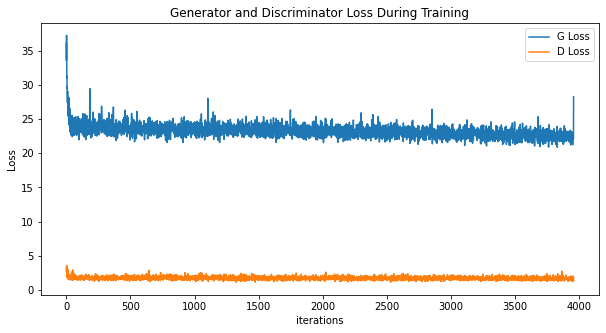

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(hist_G,label="G Loss")
plt.plot(hist_D,label="D Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

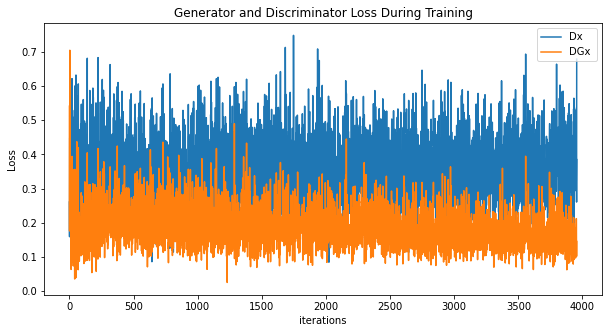

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(hist_Dx,label="Dx")
plt.plot(hist_DGx,label="DGx ")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

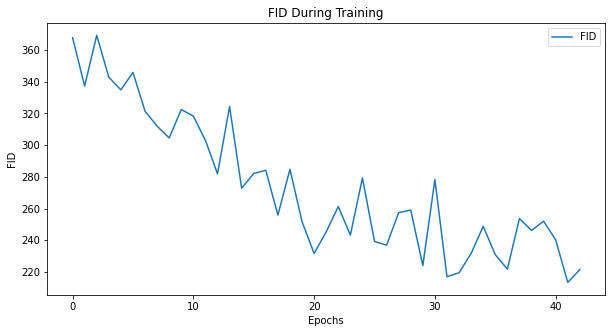

In [13]:
plt.figure(figsize=(10,5))
plt.title("FID During Training")
plt.plot(hist_FID,label="FID")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

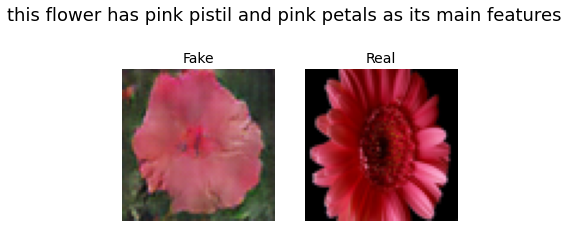

In [47]:
import matplotlib.pyplot as plt

save_path = './'
 
for sample in data_loader:
    right_images = sample['right_images']
    right_embed = sample['right_embed']
    txt = sample['txt']

    right_images = Variable(right_images.float()).to(device)
    right_embed = Variable(right_embed.float()).to(device)

    # Train the generator
    noise = Variable(torch.randn(right_images.size(0), 100)).to(device)
    noise = noise.view(noise.size(0), 100, 1, 1)
    fake_images = netG(right_embed, noise)
 
    for image, t in zip(fake_images, txt):
        im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(t, fontsize=18)
        ax1.imshow(im)
        ax1.axis("off")
        ax1.set_title('Fake', fontsize=14)
        im = Image.fromarray(right_images[0].data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
        ax2.imshow(im)
        ax2.set_title('Real', fontsize=14)
        ax2.axis("off")
        break
    break

### Evaluation

In [ ]:
pip install torchfile

  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5712 sha256=866319fccb48c777be12ddac2dc05686eebde535e9de39d8bbd251c3a996982a
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchfile


In [ ]:
from utils.basic_utils import extract_char_cnn_rnn_weights

# extract weights from original models
net_state_dict = extract_char_cnn_rnn_weights( './models/lm_sje_flowers_c10_hybrid_0.00070_1_10_trainvalids.txt_iter16400.t7')

Ours pretrained model:

In [ ]:
net_state_dict = torch.load('./models/cnn_rnn/cnn_rnn_0.00040_True_train_2021_07_01_09_51_47.pth')

In [ ]:
from models.char_cnn_rnn import char_cnn_rnn


# create Char-CNN-RNN model and load weights
net = char_cnn_rnn()
#net.load_state_dict(torch.load(args.weights_out_path))
net.load_state_dict(net_state_dict)
net = net.to(device)
net.eval()
print(net)

char_cnn_rnn(
  (conv1): Conv1d(70, 384, kernel_size=(4,), stride=(1,))
  (threshold1): Threshold(threshold=1e-06, value=0)
  (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(384, 512, kernel_size=(4,), stride=(1,))
  (threshold2): Threshold(threshold=1e-06, value=0)
  (maxpool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(512, 512, kernel_size=(4,), stride=(1,))
  (threshold3): Threshold(threshold=1e-06, value=0)
  (maxpool3): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): fixed_rnn(
    (i2h): Linear(in_features=512, out_features=512, bias=True)
    (h2h): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_proj): Linear(in_features=512, out_features=1024, bias=True)
)


To use your trained model, call model.eval() to disable further training. This stops BatchNorm layers from updating their mean and variance, and allows input of just one sample. Use model.train() to resume training mode, if needed.

In [ ]:
netG.eval()

generator(
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (netG): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


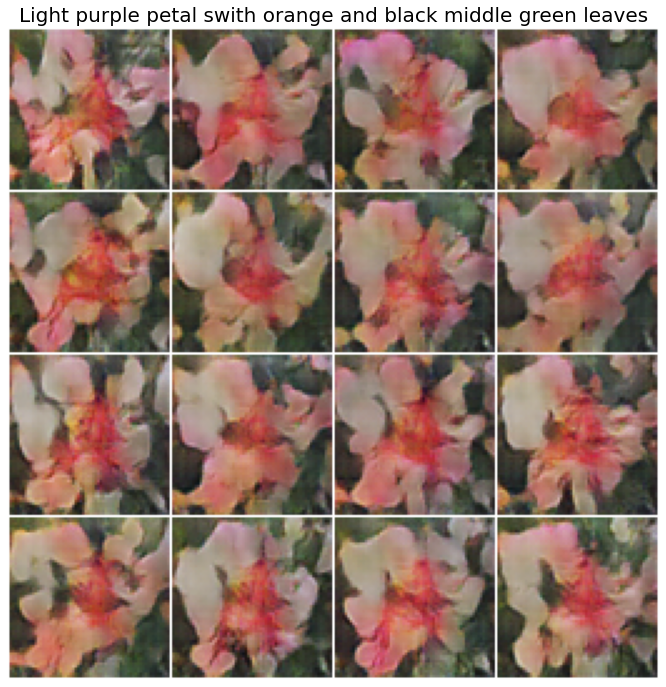

In [ ]:
import matplotlib.pyplot as plt
from utils.text_utils import prepare_text

# captionText = 'Anything but a flower please'
captionText = 'Light purple petal swith orange and black middle green leaves'

caption = prepare_text(captionText)
caption = caption.unsqueeze(0).to(device)

embed = net(caption).to(device)
embed = Variable(embed.float()).to(device)
 

 
img_list = []
for i in range(16):
  if i>0:
    prev = img
  # Train the generator
  noise = Variable(torch.randn(1, 100)).to(device)
  noise = noise.view(noise.size(0), 100, 1, 1)

  fake_image = netG(embed, noise)
  
  img = fake_image.data.mul_(127.5).add_(127.5).byte()
  if i > 0:
    img = torch.cat((prev,img))

import torchvision

fig = plt.figure(  figsize=(12, 12))

plt.title(captionText, fontsize=20)
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(img.cpu(), nrow=4, padding=1,pad_value = 255).permute(1, 2, 0))